In [25]:
import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from functools import reduce
import time
import re
import seaborn as sns

from pism_ragis.analysis import sensitivity_analysis
from pism_ragis.processing import convert_netcdf_to_dataframe, check_paleo_file, copy_file
from pism_ragis.stats import run_stats

In [2]:
data_dir = "/data/work/gris-paleo/data/"

grid = 9000
exp = {"Experiment": "climate-calving",
        "proj_dir": "2024_01_climate_float_kill",
        "scalar_dir": "scalar",
        "processed_dir": "processed_scalar",
        "fig_dir": "figures",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
fig_dir = os.path.join(data_dir, exp["proj_dir"], exp["fig_dir"])
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

scalar_files = sorted(glob(os.path.join(s_dir, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])
for scalar_file in scalar_files:
    if check_paleo_file:
        copy_file(scalar_file, processed_path)
processed_files = sorted(glob(os.path.join(processed_path, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))
print(processed_files)



['/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_0_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_10_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_11_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_12_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_13_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_14_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_15_-125001_0.nc', '/data/work/gris-paleo/data/2024_01_climate_float_kill/processed_scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_16_-125001_0.nc', '/data/w

In [3]:
n_jobs = 10

In [4]:
def to_year(x):
    return x.year

In [9]:
def preprocess_nc(ds):
    m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
    ds.expand_dims("id")
    assert m_id_re is not None
    m_id: Union[str, int]
    try:
        m_id = int(m_id_re.group(1))
    except:
        m_id = str(m_id_re.group(1))
    ds["id"] = m_id
    return ds.mean("nv")


In [10]:

with xr.open_mfdataset(processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=False) as ds:
    ds_df = ds.to_dask_dataframe()

In [11]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)

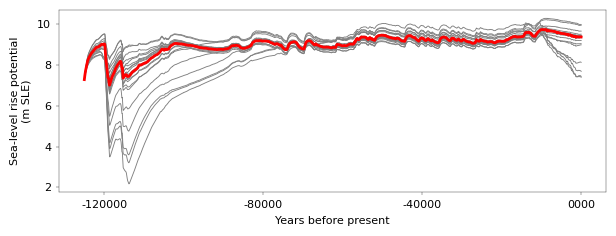

In [12]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, f"{plot_var}_paleo-ensemble-{grid}m.pdf"))

In [ ]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)

ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, f"{plot_var}_paleo-ensemble-{grid}m.pdf"))

In [13]:
sa_ens_ds = ds["sea_level_rise_potential"].resample(time="100YS").mean()

X_df = (
    sa_ens_ds.to_dataframe()
    .reset_index()
    .dropna()
    .sort_values(by=["time", "id"])
    .reset_index(drop=True)
)


In [14]:
uq_file = "../uncertainty_quantification/gris_paleo_climate-calving_w_posterior_lhs_20.csv"
uq_df = pd.read_csv(uq_file)

In [15]:
sa_df = sensitivity_analysis(X_df, ensemble_file=uq_file, n_jobs=n_jobs, calc_variables=["sea_level_rise_potential"])

-------------------------------------------



Processing date:   0%|          | 0/1251 [00:00<?, ?it/s]

Program finished in 165 seconds


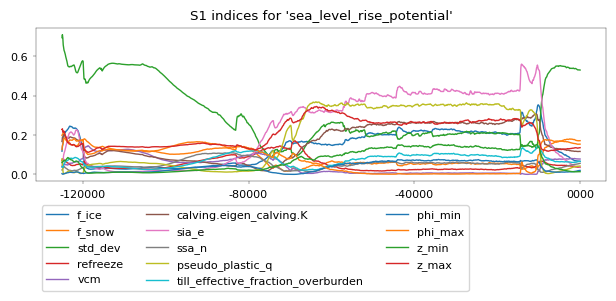

In [16]:
    si = "S1"
    outfile = f"""{si}_paleo_{grid}m.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 5.6],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, outfile))


/home/andy/miniconda3/envs/pism-ragis/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


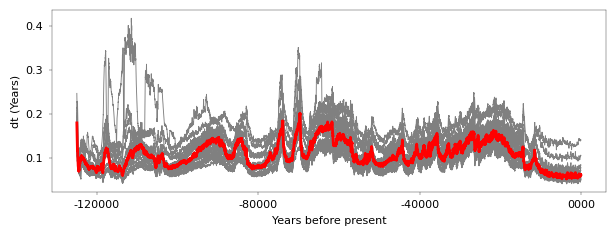

In [17]:
plot_var = "dt"
runmean_100a_ds = ds.rolling(time=100, center=True).mean()

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
runmean_100a_ds["dt"].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
runmean_100a_ds["dt"].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("dt (Years)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(f"{plot_var}_paleo-ensemble.pdf")

In [18]:
process_groups = {"Surface": ["f_ice", "f_snow", "std_dev", "refreeze"],
                 "Calving": ["vcm", "calving.eigen_calving.K"],
                 "Ice Flow": ["sia_e", "ssa_n", "pseudo_plastic_q", "till_effective_fraction_overburden", "phi_min", "phi_max", "z_min", "z_max"]
                 }

In [19]:
def merge_by_process(df: pd.DataFrame, p: str):
        df = pd.merge(df[process_groups[p]].sum(axis=1).rename("Si_value"), df[["Date", "Si", "Variable"]], left_index=True, right_index=True)
        df["Process"] = p
        return df

In [20]:
sa_by_process_dfs = [merge_by_process(sa_df, p) for p in process_groups.keys()]
sa_by_process_df = pd.concat(sa_by_process_dfs).reset_index(drop=True)
sa_by_process_df['Year'] = sa_by_process_df['Date'].apply(lambda x: x.year)

In [21]:
ensemble_df = ds["sea_level_rise_potential"].to_dataframe().reset_index()
ensemble_df["Year"] = ensemble_df["time"].apply(lambda x: x.year)

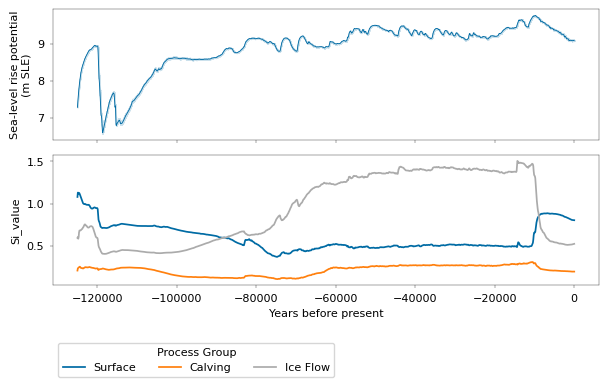

In [22]:
import seaborn as sns
plt.style.use("tableau-colorblind10")

plot_var = "sea_level_rise_potential"

si = "S1"
si_df = sa_by_process_df[sa_by_process_df["Si"] == si]
outfile = f"""{si}_by_process_paleo_g{grid}m.pdf"""
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    figsize=[6.2, 4.2],
)
fig.subplots_adjust(bottom=0.0)
ax = axs[0]
sns.lineplot(data=ensemble_df, x="Year", y="sea_level_rise_potential", errorbar=("ci", False), ax=ax, legend=False)
# sns.lineplot(data=ensemble_df, x="Year", y="sea_level_rise_potential", ax=ax, legend=False)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax = axs[1]
sns.lineplot(data=si_df, x="Year", y="Si_value", hue="Process", lw=1.25, ax=ax)
legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75), title="Process Group")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, outfile))



In [23]:
ensemble_df["sea_level_rise_potential"].median(axis="time")

ValueError: No axis named time for object type Series

In [ ]:
ens_df

In [ ]:
ensemble_df

In [36]:
ds.isel(time=range(0, 100))

<xarray.Dataset>
Dimensions:                                         (time: 100, id: 20)
Coordinates:
  * time                                            (time) object -124999-01-...
  * id                                              (id) float64 0.0 ... 9.0
Data variables: (12/43)
    pism_config                                     (id) float64 0.0 0.0 ... 0.0
    run_stats                                       (id) float64 0.0 0.0 ... 0.0
    time_bounds                                     (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    basal_mass_flux_floating                        (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    basal_mass_flux_grounded                        (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    dt                                              (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    ...                                              ...
    tendency_of_ice_mass_due_to_discharge           (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    tendency_of_ice_mass_due_to_flow                (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    tendency_of_ice_mass_due_to_surface_mass_flux   (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    tendency_of_ice_mass_glacierized                (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    tendency_of_ice_volume                          (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    tendency_of_ice_volume_glacierized              (id, time) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>

In [30]:
ds.sel(time=slice(xr.cftime_range("-122000-1-1", "-120000-1-1")), method="nearest")

ValueError: no ISO-8601 or cftime-string-like match for string: -122000-1-1

In [35]:
import numpy as np